In [1]:
from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import malthus, verhulst, gompertz, runge_kutta

In [2]:
T0 = 0
TF = 1
H = 0.01
X0 = 5
K = 0.6

T, X = runge_kutta(malthus, T0, X0, TF, H, K)

In [3]:
NUM_GERACOES = 5000
TAMANHO_POP = 1000
TAMANHO_TORNEIO = 3
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.03

In [4]:
def Div(left, right):
    if type(right) == float:
        if right == 0:
            #print('div error')
            return 1
        else:
            return left / right
    else:
        # Replace zero terms in the divider array with 1
        right_without_zeros = np.where(right == 0, 1, right)

        # Perform element-wise division
        result = left / right_without_zeros
        return result

def Exp(x):
    try:
        result = np.exp(x)
    except OverflowError:
        print('exp error')
        result = np.ones_like(x)
    return result

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
#pset.addPrimitive(np.cos, 1)
#pset.addPrimitive(np.sin, 1)
pset.addPrimitive(Exp, 1)

#pset.addPrimitive(X0_add, 1)
#pset.addPrimitive(X0_mul, 1)
#pset.addPrimitive(X0_div, 1)
#pset.addPrimitive(K_add, 1)
#pset.addPrimitive(K_mul, 1)
#pset.addPrimitive(K_div, 1)

pset.addEphemeralConstant("rand101", lambda: rd.randint(-1,1))

pset.renameArguments(ARG0='t')

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [6]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [7]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 40:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

In [10]:
pop = toolbox.population(n=TAMANHO_POP)
hof = tools.HallOfFame(5)
eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=False)
a = 1

c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_16264/2186209511.py:18: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)
C:\Users\MARCOS~1\AppData\Local\Temp/ipykernel_16264/1914576775.py:6: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))


In [11]:
for i in hof.items:
    print(str(i))
    print()

add(neg(t), add(Exp(1), Exp(add(t, 1))))

add(Exp(add(1, t)), add(Exp(1), neg(t)))

add(add(Exp(1), neg(t)), Exp(add(1, t)))

add(add(Exp(1), neg(t)), Exp(add(t, 1)))

add(Exp(add(t, 1)), add(Exp(1), neg(t)))



add(neg(t), add(Exp(1), Exp(add(t, 1))))


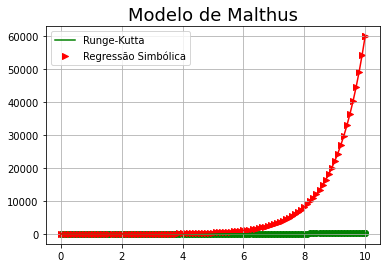

In [12]:
T0 = 0
TF = 10
H = 0.1
X0 = 5
K = 0.4

T, X = runge_kutta(malthus, T0, X0, TF, H, K)

melhor_individuo = str(hof.items[0])
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Malthus', size = 18)
ax.scatter(T, X, c = 'g')
ax.plot(T, X, label = 'Runge-Kutta', c = 'g')
ax.scatter(T, Xexpr, label = 'Regressão Simbólica', marker = '>', c = 'r')
ax.plot(T, Xexpr, c = 'r')
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('Malthus.png', dpi = 200)

In [13]:
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

def X0_add(x):
    return x + X0

def X0_mul(x):
    return x * X0

def X0_div(x):
    return x / X0

def X0_sub(x):
    return x - X0

def K_add(x):
    return x + K

def K_mul(x):
    return x * K

def K_div(x):
    return x / K

def k_sub(x):
    return x - K

    
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)


new_pset.addEphemeralConstant("rand102", lambda: rd.randint(-1,1))

new_pset.renameArguments(ARG0='t')
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

In [15]:
display(sp.expand(func(t)))

-t + E*exp(t) + E